# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
First release: *18th March 2025*

This first extension (X1) of Neuropolis includes fourteen Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

*04: Regression Models*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Large Language Models*

*10: Large Language Model Chain-of-Thought*

*11: Large Language Model Fine-Tuning*

***12: Large Multimodal Model***

*13: Statistical Tests*

*14: Tables and Figures*

### Notebook 12

# **Large Multimodal Model**

## **1. Topographic Map**

We retrieve the EEG montage, and create a **topographic map** showing the beta bandpower across all EEG channels. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mne
import pickle
import io
from PIL import Image
import torch
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from fvcore.nn import FlopCountAnalysis
import logging

In [2]:
# Define the raw data path. 
raw_data_path = '../../Neuropolis/ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the features and the targets for the classification task. 
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)
with open(preprocessed_data_path + 'dict_features_bandpowers_normalized.p', 'rb') as file:
    dict_features_bandpowers = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_targets_classification_basis.p', 'rb') as file:
    dict_targets_basis_class = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve and display the total number of scans. 
nb_scans_total = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]
nb_scans_total

200

In [5]:
# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Display the brain region names and the number of brain regions. 
print(targets)
print(len(targets), 'brain regions')

['Background', 'Frontal Pole', 'Insular Cortex', 'Superior Frontal Gyrus', 'Middle Frontal Gyrus', 'Inferior Frontal Gyrus, pars triangularis', 'Inferior Frontal Gyrus, pars opercularis', 'Precentral Gyrus', 'Temporal Pole', 'Superior Temporal Gyrus, anterior division', 'Superior Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, anterior division', 'Middle Temporal Gyrus, posterior division', 'Middle Temporal Gyrus, temporooccipital part', 'Inferior Temporal Gyrus, anterior division', 'Inferior Temporal Gyrus, posterior division', 'Inferior Temporal Gyrus, temporooccipital part', 'Postcentral Gyrus', 'Superior Parietal Lobule', 'Supramarginal Gyrus, anterior division', 'Supramarginal Gyrus, posterior division', 'Angular Gyrus', 'Lateral Occipital Cortex, superior division', 'Lateral Occipital Cortex, inferior division', 'Intracalcarine Cortex', 'Frontal Medial Cortex', 'Juxtapositional Lobule Cortex (formerly Supplementary Motor Cortex)', 'Subcallosal Cortex', 'Paracingulate

In [6]:
# Define the bandpower names. 
bandpower_names = ['Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Sigma (12-16 Hz)', 'Beta (16-30 Hz)', 'Gamma (30-40 Hz)']

# Define the path of the header file (.vhdr) for this subject, for the eegfmriNF condition. 
vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-eegfmriNF_eeg_pp.vhdr'

# Load the EEG data using the MNE library, keeping error messages but suppressing warnings. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = 'ERROR')

# Retrieve and display the EEG montage. 
montage = channels_data.get_montage()
montage

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 63 channels>

In [7]:
# Retrieve and display the sampling frequency. 
sampling_frequency = channels_data.info['sfreq']
sampling_frequency

200.0

In [8]:
# Remove the ECG channel from the channel names. 
channel_names = channels_data.ch_names
channel_names.remove('ECG')

# Display the channel names and the number of channels. 
print(channel_names)
print(len(channel_names), 'channels')

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']
63 channels


In [9]:
# Select a condition, a bandpower index, and a scan. 
condition = 'eegfmriNF'
selected_bandpower_index = 4
selected_scan = 10

# Retrieve the bandpower data. 
bandpower_data = dict_features_bandpowers[subject][condition][:, selected_bandpower_index, selected_scan]
bandpower_data.shape

(63,)

In [10]:
# Create the measurement information object. 
info = mne.create_info(ch_names = montage.ch_names, sfreq = sampling_frequency, ch_types = 'eeg')
info.set_montage(montage)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 63
 projs: []
 sfreq: 200.0 Hz
>

In [11]:
# Define a function to create a topographic map image. 
def create_topomap_image(bandpower_data, info):
    
    # Create the evoked potential array. 
    evoked = mne.EvokedArray(bandpower_data[:, np.newaxis], info)

    # Generate the topographic map, and save it into a BytesIO buffer. 
    fig = evoked.plot_topomap(times = [0], scalings = 1, cmap = 'coolwarm', contours = 0, show = False)
    buffer = io.BytesIO()
    fig.savefig(buffer, format = 'png', bbox_inches = 'tight')
    buffer.seek(0) # Reset the pointer to the beginning of the stream. 

    # Convert the figure to a PIL Image, then close the figure to free memory. 
    topomap_image = Image.open(buffer)
    plt.close(fig)

    # Resize the topographic map, and ensure it has RGB channels. 
    topomap_image = topomap_image.resize((224, 224), Image.Resampling.LANCZOS)
    topomap_image = topomap_image.convert('RGB')
    
    return topomap_image

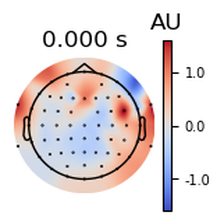

In [12]:
# Create and display a topographic map image. 
topomap_image = create_topomap_image(bandpower_data, info)
topomap_image

In [13]:
# Define dictionaries to store the brain regions, sequences of fMRI scans, and FLOPs. 
dict_brain_regions = dict()
dict_fmri_scans = dict()
dict_flops = dict()

## **2. PaliGemma**

We use the **PaliGemma2-3B-Mix-224 large multimodal model**, and select its hyperparameters in order to ensure a relative variety of responses. We define a prompt where we provide a topographic map of the beta bandpower, and ask the model to predict the corresponding fMRI activity. We run the large multimodal model on the eegfmriNF condition of all subjects, for a selection of brain regions spanning both a substantial fraction of the brain and a variety of cognitive functions. In the bar plot presenting the results, an indicative baseline is given for visualization purposes, but the real baseline depends both on the selected fMRI scans and the distribution of missing or ambiguous predictions. 

In [14]:
# Define the LMM to use. 
model_name = 'google/paligemma2-3b-mix-224'

# Load the processor and the model. 
processor_paligemma = AutoProcessor.from_pretrained(model_name, use_fast = True)
model_paligemma = PaliGemmaForConditionalGeneration.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
# Define a function to create a LMM prompt. 
def prompt_lmm(selected_bandpower, selected_brain_region):

    # Create the prompt. 
    prompt = (
        f"<image>A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. "
        f"This EEG topographic map shows the brain activity pattern observed for the band power {selected_bandpower}. "
        f"The fMRI BOLD signal was measured in the {selected_brain_region} four seconds after that. "
        f"Given the EEG data, is the fMRI signal in this brain region likely increasing or decreasing? "
        f"Base your answer on your general knowledge in neuroscience, EEG research, and fMRI research. "
        f"Please answer with only one word: Increasing or Decreasing. Just give your best prediction, without any explanation."
    )

    return prompt

In [16]:
# Define a function to run a LMM. 
def run_lmm(prompt, image, processor, model):

    # Run the LMM. 
    inputs = processor(images = image, text = prompt, return_tensors = 'pt').to(model.device)
    output = model.generate(**inputs, 
                            max_new_tokens = 20, 
                            temperature = 1.2, 
                            top_p = 0.9, 
                            top_k = 50, 
                            do_sample = True, 
                            repetition_penalty = 1)

    # Decode the generated text, remove the original prompt, and return the answer. 
    generated_text = processor.decode(output[0], skip_special_tokens = True)
    answer_only = generated_text[len(prompt[7:]):].strip()
    
    return answer_only

In [17]:
# Define a function to run a LMM multiple times. 
def run_lmm_series(X, Y, fmri_scans, selected_bandpower_index, selected_brain_region, info, processor, model):

    # Create the NumPy arrays to store the true values and predictions.     
    Y_true = np.zeros(len(fmri_scans))
    Y_pred = np.zeros(len(fmri_scans))
    answers = []
    counter = 0

    # Iterate through all selected fMRI scans. 
    for fmri_scan_index in fmri_scans:

        # Create the topographic map image. 
        topomap_image = create_topomap_image(X[:, fmri_scan_index], info)

        # Create the LMM prompt. 
        selected_bandpower = bandpower_names[selected_bandpower_index]
        prompt = prompt_lmm(selected_bandpower, selected_brain_region)
        
        # Run the LMM and store the result. 
        answer_only = run_lmm(prompt, topomap_image, processor, model)
        answers.append(answer_only) # For debugging purposes. 

        # Analyze the answer. 
        increase_detected = 'increas' in answer_only.lower()
        decrease_detected = 'decreas' in answer_only.lower()
        if increase_detected and not decrease_detected:
            Y_pred[counter] = 1
        elif decrease_detected and not increase_detected:
            Y_pred[counter] = 0
        else:
            Y_pred[counter] = -1

        # Store the true value, which is the fMRI signal two scans later, at the peak of the hemodynamic response. 
        Y_true[counter] = Y[fmri_scan_index + 2]

        # Increment. 
        counter += 1

    return Y_true, Y_pred

In [18]:
# Select a subject, a condition, and a scan. 
subject = 'sub-xp101'
condition = 'eegfmriNF'
selected_scan = 5

# Select a fMRI brain region and an EEG bandpower. 
selected_brain_region = 'Frontal Pole'
selected_brain_region_index = list(targets).index(selected_brain_region)
selected_bandpower_index = 4
selected_bandpower = bandpower_names[selected_bandpower_index]

# Display the fMRI brain region and the EEG bandpower. 
print('Brain region:', selected_brain_region)
print('Brain region index:', int(selected_brain_region_index))
print('EEG bandpower:', selected_bandpower)

Brain region: Frontal Pole
Brain region index: 1
EEG bandpower: Beta (16-30 Hz)


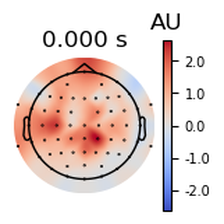

In [19]:
# Retrieve the bandpower data. 
bandpower_data = dict_features_bandpowers[subject][condition][:, selected_bandpower_index, selected_scan]

# Create and display the topographic map image. 
topomap_image = create_topomap_image(bandpower_data, info)
topomap_image

In [20]:
# Create the LMM prompt. 
prompt = prompt_lmm(selected_bandpower, selected_brain_region)
prompt[7:]

'A human subject participated in a neuroscience experiment where EEG data and fMRI data were recorded simultaneously. This EEG topographic map shows the brain activity pattern observed for the band power Beta (16-30 Hz). The fMRI BOLD signal was measured in the Frontal Pole four seconds after that. Given the EEG data, is the fMRI signal in this brain region likely increasing or decreasing? Base your answer on your general knowledge in neuroscience, EEG research, and fMRI research. Please answer with only one word: Increasing or Decreasing. Just give your best prediction, without any explanation.'

In [21]:
# Run the LMM once, and display the result. 
answer_only = run_lmm(prompt, topomap_image, processor_paligemma, model_paligemma)
answer_only

'Increasing'

In [22]:
# Retrieve the features for the selected subject, condition, and EEG bandpower. 
X = dict_features_bandpowers[subject][condition][:, selected_bandpower_index, 1:]

# Retrieve the targets for the selected subject, condition, and fMRI brain region. 
Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

# Display the shape of the features and the targets.
print('X shape:', X.shape)
print('Y shape:', Y.shape)

X shape: (63, 199)
Y shape: (199,)


In [23]:
# Run the LMM multiple times. 
fmri_scans = range(5, (nb_scans_total - 3), 20)
Y_true, Y_pred = run_lmm_series(X, Y, fmri_scans, selected_bandpower_index, selected_brain_region, info, processor_paligemma, model_paligemma)

# Compute the average accuracy. 
accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
accuracy_sequence

0.4444444444444444

In [24]:
# Select a condition, a bandpower index, and a list of brain regions. 
condition = 'eegfmriNF'
selected_bandpower_index = 4
brain_regions = ['Frontal Pole', # High-order cognitive functions, but sometimes noisy EEG signal. 
                 'Insular Cortex', # Integrative functions. 
                 'Inferior Frontal Gyrus, pars triangularis', # Language and executive functions. 
                 'Precentral Gyrus', # Primary motor cortex. 
                 'Superior Temporal Gyrus, posterior division', # Auditory functions. 
                 'Superior Parietal Lobule', # Attention functions. 
                 'Angular Gyrus', # Default-mode network. 
                 'Occipital Pole'] # Primary visual cortex. 

# Select a sequence of fMRI scans. 
fmri_scans = range(5, (nb_scans_total - 1), 20) # Extensive search.
#fmri_scans = range(5, (nb_scans_total - 1), 100) # Quick search for debugging.

# Store the brain regions and the sequence of fMRI scans in dictionaries. 
dict_brain_regions['Large Multimodal Model'] = brain_regions
dict_fmri_scans['Large Multimodal Model'] = fmri_scans

# Define a dictionary to store the predictions and a Pandas DataFrame to store the accuracy. 
dict_predictions_paligemma = dict()
accuracy_summary_paligemma = pd.DataFrame(columns = brain_regions)

# Retrieve the selected bandpower. 
selected_bandpower = bandpower_names[selected_bandpower_index]

# Iterate through all brain regions. 
for selected_brain_region in brain_regions:

    # Display the current brain region. 
    print(selected_brain_region)

    # Define a dictionary to store the predictions for this brain region. 
    dict_predictions_paligemma[selected_brain_region] = dict()

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the features for the selected subject, condition, and EEG bandpower. 
        X = dict_features_bandpowers[subject][condition][:, selected_bandpower_index, 1:]

        # Retrieve the targets for the selected subject, condition, and fMRI brain region. 
        Y = dict_targets_basis_class[subject][condition][:, selected_brain_region_index]

        # Run the LMM multiple times. 
        Y_true, Y_pred = run_lmm_series(X, Y, fmri_scans, selected_bandpower_index, selected_brain_region, info, processor_paligemma, model_paligemma)

        # Store the predictions. 
        dict_predictions_paligemma[selected_brain_region][subject] = Y_pred

        # Compute and store the average accuracy. 
        accuracy_array = Y_pred[Y_pred != -1] == Y_true[Y_pred != -1]
        accuracy_sequence = np.sum(accuracy_array) / accuracy_array.shape[0]
        accuracy_summary_paligemma.loc[subject, selected_brain_region] = accuracy_sequence

        # Display the number of ambiguous predictions. 
        print(subject + ': ' + str(np.sum(Y_pred == -1)), 'ambiguous prediction(s) out of', len(Y_pred), '-', str(np.sum(Y_pred == -1) / len(Y_pred) * 100), '%')

Frontal Pole
sub-xp101: 3 ambiguous prediction(s) out of 10 - 30.0 %
sub-xp103: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp104: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp105: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp106: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp107: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp108: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp109: 3 ambiguous prediction(s) out of 10 - 30.0 %
sub-xp110: 0 ambiguous prediction(s) out of 10 - 0.0 %
Insular Cortex
sub-xp101: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp103: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp104: 2 ambiguous prediction(s) out of 10 - 20.0 %
sub-xp105: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp106: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp107: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp108: 0 ambiguous prediction(s) out of 10 - 0.0 %
sub-xp109: 1 ambiguous prediction(s) out of 10 - 10.0 %
sub-xp110: 1 ambiguous pred

In [25]:
# Set the logging level to suppress warnings. 
logging.getLogger('fvcore.nn.jit_handles').setLevel(logging.ERROR)
logging.getLogger('fvcore.nn.jit_analysis').setLevel(logging.ERROR)

# Store current device. 
device_before = next(model_paligemma.parameters()).device
print('Original device of the model:', device_before)

# Define a class wrapping the model. 
# We output only logits (Tensor data type) for compatibility with FlopCountAnalysis. 
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, input_ids):
        output = self.model(input_ids)
        return output.logits

# Move the model to CPU and prepare dummy input for FLOPs analysis. 
model_paligemma_cpu = WrappedModel(model_paligemma).to('cpu')
dummy_input = (torch.ones((1, len(prompt)), dtype = torch.long),) # batch_size = 1, seq_len = prompt length
print('Prompt length:', len(prompt))

# Measure the FLOPs. 
flops = FlopCountAnalysis(model_paligemma_cpu, dummy_input)
print(f'Total FLOPs: {flops.total():,}')
print('FLOPs by operator:', flops.by_operator())

# Move the model back to its original device. 
model_paligemma.to(device_before)
print('Model moved back to:', device_before)

Original device of the model: cpu
Prompt length: 608
Total FLOPs: 1,591,076,270,080
FLOPs by operator: Counter({'linear': 1591076192256, 'matmul': 77824})
Model moved back to: cpu


In [26]:
# Store and display the number of FLOPs. 
dict_flops['Large Multimodal Model'] = flops.total()
print('FLOPs per inference:', flops.total())

FLOPs per inference: 1591076270080


In [27]:
# Display the accuracies per subject and brain region. 
accuracy_summary_paligemma

,Frontal Pole,Insular Cortex,"Inferior Frontal Gyrus, pars triangularis",Precentral Gyrus,"Superior Temporal Gyrus, posterior division",Superior Parietal Lobule,Angular Gyrus,Occipital Pole
sub-xp101,0.285714,0.111111,0.333333,0.6,0.444444,0.625,0.222222,0.5
sub-xp103,0.333333,0.333333,0.6,0.5,0.2,0.2,0.333333,0.5
sub-xp104,0.3,0.5,0.75,0.444444,0.555556,0.333333,0.4,0.4
sub-xp105,0.5,0.555556,0.666667,0.777778,0.3,0.5,0.444444,0.3
sub-xp106,0.7,0.4,0.5,0.375,0.6,0.333333,0.5,0.5
sub-xp107,0.444444,0.3,0.7,0.333333,0.333333,0.3,0.3,0.4
sub-xp108,0.555556,0.6,0.444444,0.6,0.3,0.6,0.5,0.222222
sub-xp109,0.571429,0.555556,0.4,0.666667,0.666667,0.5,0.5,0.444444
sub-xp110,0.7,0.666667,0.5,0.444444,0.666667,0.5,0.777778,0.666667


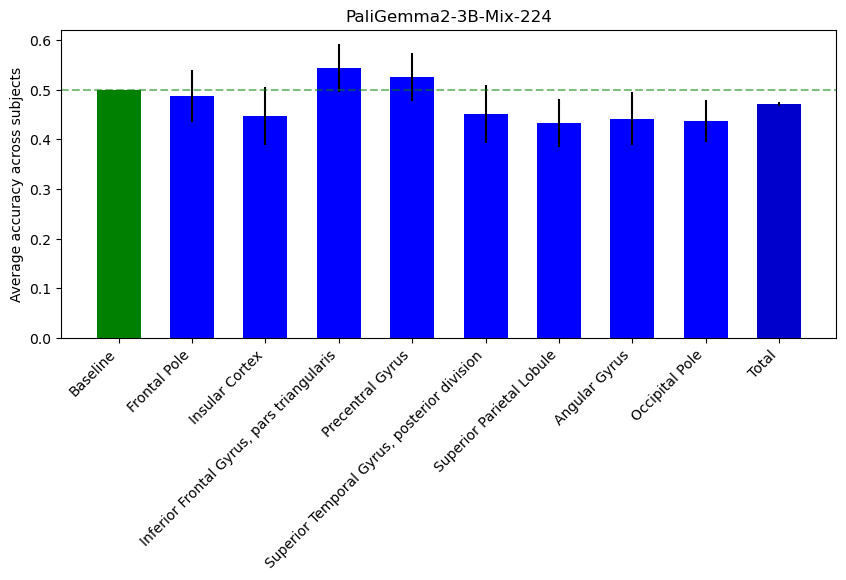

In [28]:
# Retrieve the average accuracy across subjects, and the standard error of the accuracy across subjects. 
accuracy_mean = list(accuracy_summary_paligemma.mean().values)
accuracy_mean.insert(0, 0.5) # Insert a baseline average of 0.5. 
accuracy_se = list(accuracy_summary_paligemma.std().values / np.sqrt(len(subjects)))
accuracy_se.insert(0, 0) # Insert a baseline standard error of 0. 

# Append the total average accuracy and its standard error. 
nb_brain_regions = accuracy_summary_paligemma.shape[1]
accuracy_mean.append(np.mean(accuracy_mean[1:]))
accuracy_se.append(np.std(accuracy_mean[1:]) / (np.sqrt(len(subjects) * nb_brain_regions)))

# Create the labels. 
labels = brain_regions.copy()
labels.insert(0, 'Baseline')
labels.append('Total')

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 4))
axes.bar(range(nb_brain_regions + 2), accuracy_mean, width = 0.6, color = ['green', *['blue'] * nb_brain_regions, 'mediumblue'])
axes.errorbar(range(nb_brain_regions + 2), accuracy_mean, yerr = accuracy_se, fmt = 'None', color = 'black')
axes.axhline(accuracy_mean[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(nb_brain_regions + 2), labels = labels)
axes.set_xticklabels(labels, rotation = 45, ha = 'right')
axes.set_ylabel('Average accuracy across subjects')
axes.set_title('PaliGemma2-3B-Mix-224');

## **3. Results**

In [29]:
# Save the predictions into a Pickle file. 
with open(results_path + 'classification/dict_predictions_paligemma.p', 'wb') as file:
    pickle.dump(dict_predictions_paligemma, file)

# Save the summary into a Pickle file. 
with open(results_path + 'classification/df_summary_paligemma.p', 'wb') as file:
    pickle.dump(accuracy_summary_paligemma, file)

# Save the brain regions, sequences of fMRI scans, and FLOPs into Pickle files. 
with open(results_path + 'brain_regions_large_multimodal_model.p', 'wb') as file:
    pickle.dump(dict_brain_regions, file)
with open(results_path + 'fmri_scans_large_multimodal_model.p', 'wb') as file:
    pickle.dump(dict_fmri_scans, file)
with open(results_path + 'flops_large_multimodal_model.p', 'wb') as file:
    pickle.dump(dict_flops, file)